In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import copy

In [2]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_sim.utils import ddf_locations

In [3]:
opsdb = maf.OpsimDatabase(get_baseline())
runName = os.path.split(get_baseline())[-1].replace('.db', '')
print(runName)

baseline_v2.0_10yrs


In [4]:
# fov is on the order of 3 deg across (180 arcmin)
# dithers on the order of 0.5 deg (30 arcmin)
# chip gaps are less than 1 arcmin
radius = np.radians(3)
#nside = 2048
nside = 1024
hp.nside2resol(nside, arcmin=True), hp.nside2npix(nside)

(3.435486411817406, 12582912)

In [5]:
ddfs = ddf_locations()
ddfs

{'ELAISS1': (9.45, -44.0),
 'XMM_LSS': (35.708333, -4.75),
 'ECDFS': (53.125, -28.1),
 'COSMOS': (150.1, 2.1819444444444445),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6)}

In [6]:
k = 'COSMOS'
vec = hp.ang2vec(ddfs[k][0], ddfs[k][1], lonlat=True)
pixs = hp.query_disc(nside, vec, radius)
len(pixs), hp.nside2npix(64), len(pixs) / hp.nside2npix(64)

(8619, 49152, 0.17535400390625)

In [7]:
ra, dec = hp.pix2ang(nside, pixs, lonlat=True)

In [8]:
slicer = maf.HealpixSubsetSlicer(nside, pixs)
#slicer = maf.UserPointsSlicer(ra, dec)
m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')

Healpix slicer using NSIDE=1024, approximate resolution 3.435486 arcminutes


In [9]:
bundle = maf.MetricBundle(m1, slicer, None, runName=runName, metadata=k)

In [10]:
%%time
outDir = 'ddf_test'
g = maf.MetricBundleGroup({'0': bundle}, opsdb, outDir=outDir)
g.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'fieldDec', 'observationStartMJD', 'fieldRA'].
Found 2086980 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 3min 2s, sys: 2.63 s, total: 3min 5s
Wall time: 3min 5s


In [11]:
#slicer = maf.HealpixSubsetSlicer(nside, pixs)
s = maf.UserPointsSlicer(ra, dec)
m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
b1 = maf.MetricBundle(m1, s, None, runName=runName, metadata=k)

In [12]:
%%time
outDir = 'ddf_test'
g = maf.MetricBundleGroup({'0': b1}, opsdb, outDir=outDir)
g.runAll()

Querying database observations with no constraint for columns ['rotSkyPos', 'fieldDec', 'observationStartMJD', 'fieldRA'].
Found 2086980 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 46.9 s, sys: 2.19 s, total: 49.1 s
Wall time: 49.1 s


(0.0, 3000.0)

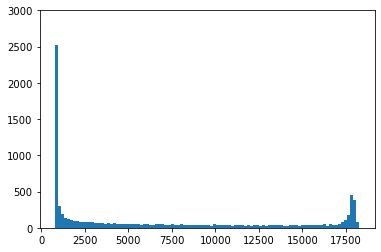

In [13]:
n, b, p = plt.hist(bundle.metricValues.compressed(), bins=100)
plt.ylim(0, 3000)

In [14]:
# have to plug the metric values into a wider healpix size map if we want to use healpix projections

skymap = np.zeros(hp.nside2npix(nside), float)
skymap[pixs] = b1.metricValues
mask = np.ones(hp.nside2npix(nside), bool)
mask[pixs] = False

newbundle = maf.MetricBundle(m1, maf.HealpixSlicer(nside), None, runName=runName, metadata=k)
newbundle.metricValues = np.ma.MaskedArray(data=skymap, mask=mask, fill_value=-666)

Healpix slicer using NSIDE=1024, approximate resolution 3.435486 arcminutes


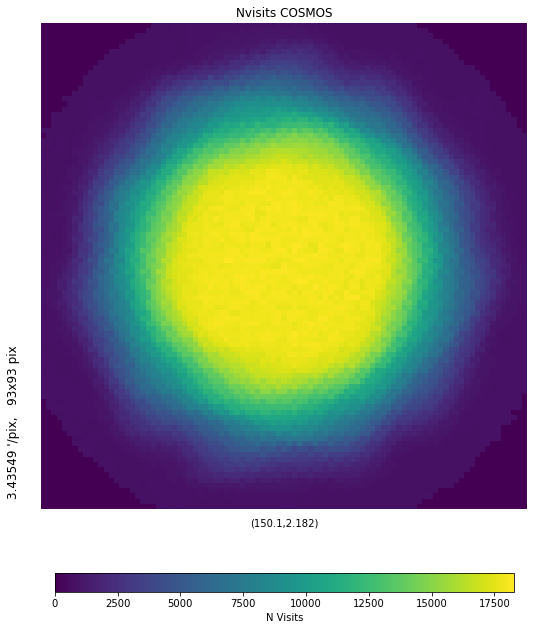

In [15]:
rot = (ddfs[k][0], ddfs[k][1], 0)
reso = hp.nside2resol(nside, arcmin=True)
xsize = int(np.ceil(np.sqrt(len(pixs))))

fig = plt.figure(figsize=(10, 10))
hp.gnomview(skymap, fig, rot=rot, xsize=xsize, reso=reso, flip='astro', title='', cbar=False)#, min=15000)
plt.title(f'Nvisits {k}')
# fix bad color bar
ax = plt.gca()
im = ax.get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal', extendrect=True)
xlabel = 'N Visits'
cb.set_label(xlabel)

In [16]:
bundles = {}
single_fields = ['ELAISS1', 'XMM_LSS', 'ECDFS', 'COSMOS' ]
double_fields = [['EDFS_a', 'EDFS_b']]
nside = 1024
for k in single_fields:
    name = k
    radius = np.radians(3)
    vec = hp.ang2vec(ddfs[k][0], ddfs[k][1], lonlat=True)
    pixs = hp.query_disc(nside, vec, radius)
    ra, dec = hp.pix2ang(nside, pixs, lonlat=True)
    slicer = maf.UserPointsSlicer(ra, dec)
    m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
    rot = (ddfs[k][0], ddfs[k][1], 0)
    reso = hp.nside2resol(nside, arcmin=True)
    xsize = int(np.ceil(np.sqrt(len(pixs))))
    plotDict = {'rot': rot, 'reso': reso, 'xsize': xsize, 'nside': nside,
               'pixs': pixs}
    nvisits = maf.MetricBundle(m1, slicer, None, runName=runName, metadata=name,
                                 plotDict=plotDict)
    bundles[name + ' nvisits '] = nvisits
    tgaps, p = maf.timeGaps(extraMetadata=name, runName=runName, slicer=slicer)
    for key in tgaps:
        tgaps[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = tgaps[key]
    intranight, p = maf.intraNight(extraMetadata=k, runName=runName, slicer=slicer)
    for key in intranight:
        intranight[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = intranight[key]
    internight, p = maf.interNight(extraMetadata=name, runName=runName, slicer=slicer)
    for key in internight:
        internight[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = internight[key]
    seasons, p = maf.seasons(extraMetadata=name, runName=runName, slicer=slicer)
    for key in seasons:
        seasons[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = seasons[key]
for k in double_fields:
    name = k[0].split('_')[0]
    radius = np.radians(3 * 2)
    vec1 = hp.ang2vec(ddfs[k[0]][0], ddfs[k[0]][1], lonlat=True)
    vec2 = hp.ang2vec(ddfs[k[1]][0], ddfs[k[1]][1], lonlat=True)
    vec = (vec1 + vec2)/2.0
    pting = hp.vec2ang(vec, lonlat=True)
    pixs = hp.query_disc(nside, vec, radius)
    ra, dec = hp.pix2ang(nside, pixs, lonlat=True)
    slicer = maf.UserPointsSlicer(ra, dec)
    m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
    rot = (pting[0][0], pting[1][0], 0)
    reso = hp.nside2resol(nside, arcmin=True)
    xsize = int(np.ceil(np.sqrt(len(pixs))))
    plotDict = {'rot': rot, 'reso': reso, 'xsize': xsize, 'nside': nside, 'pixs': pixs}
    nvisits = maf.MetricBundle(m1, slicer, None, runName=runName, metadata=name,
                                 plotDict=plotDict)
    bundles[name + ' nvisits'] = nvisits
    tgaps, p = maf.timeGaps(extraMetadata=name, runName=runName, slicer=slicer)
    for key in tgaps:
        tgaps[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = tgaps[key]
    intranight, p = maf.intraNight(extraMetadata=name, runName=runName, slicer=slicer)
    for key in intranight:
        intranight[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = intranight[key]
    internight, p = maf.interNight(extraMetadata=name, runName=runName, slicer=slicer)
    for key in internight:
        internight[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = internight[key]
    seasons, p = maf.seasons(extraMetadata=name, runName=runName, slicer=slicer)
    for key in seasons:
        seasons[key].setPlotDict(plotDict)
        bundles[name + ' ' + key] = seasons[key]

In [17]:
g = maf.MetricBundleGroup(bundles, opsdb, outDir)
g.runAll()

Querying database observations with no constraint for columns ['visitExposureTime', 'night', 'rotSkyPos', 'fieldDec', 'observationStartMJD', 'fieldRA'].
Found 2086980 visits
Running:  ['ELAISS1 nvisits ']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_Tgaps_observationStartMJD_ELAISS1_all_bands_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_TgapsPercent_2-14hrs_ELAISS1_all_bands_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_TgapsPercent_1day_ELAISS1_all_bands_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_Median_Intra-Night_Gap_ELAISS1_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_NVisitsPerNight_ELAISS1_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_DeltaT_Histogram_ELAISS1_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_DeltaNight_Histogram_ELAISS1_all_bands_USER']
Completed metric generati

Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_TgapsPercent_1day_ECDFS_u_band_USER']
Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_Median_Inter-Night_Gap_ECDFS_u_band_USER']
Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_Max_Inter-Night_Gap_ECDFS_u_band_USER']
Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_Median_Season_Length_ECDFS_u_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Tgaps_observationStartMJD_COSMOS_u_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_TgapsPercent_2-14hrs_COSMOS_u_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_TgapsPercent_1day_COSMOS_u_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Median_Inter-Night_Gap_COSMOS_u_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Max_Inter-Night_Gap_COSMOS_u_band_USER']
Completed metric 

Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_TgapsPercent_2-14hrs_EDFS_i_band_USER']
Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_TgapsPercent_1day_EDFS_i_band_USER']
Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_Median_Inter-Night_Gap_EDFS_i_band_USER']
Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_Max_Inter-Night_Gap_EDFS_i_band_USER']
Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_Median_Season_Length_EDFS_i_band_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter="g" or filter="r" or filter="i" for columns ['rotSkyPos', 'fieldDec', 'observationStartMJD', 'fieldRA']
Found 1156352 visits
Running:  ['ELAISS1 baseline_v2_0_10yrs_Fraction_of_visits_in_pairs_10-60_min_gri_ELAISS1_USER']
Completed metric generation.
Running:  ['ELAISS1 baseline_v2_0_10yrs_Fraction_of_visits_in_pairs_20-90_m

Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_Max_Inter-Night_Gap_ECDFS_g_band_USER']
Completed metric generation.
Running:  ['ECDFS baseline_v2_0_10yrs_Median_Season_Length_ECDFS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Tgaps_observationStartMJD_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_TgapsPercent_2-14hrs_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_TgapsPercent_1day_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Median_Inter-Night_Gap_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Max_Inter-Night_Gap_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['COSMOS baseline_v2_0_10yrs_Median_Season_Length_COSMOS_g_band_USER']
Completed metric generation.
Running:  ['EDFS baseline_v2_0_10yrs_Tgaps_observationStartMJD_EDFS_g_band_USER']
Completed m

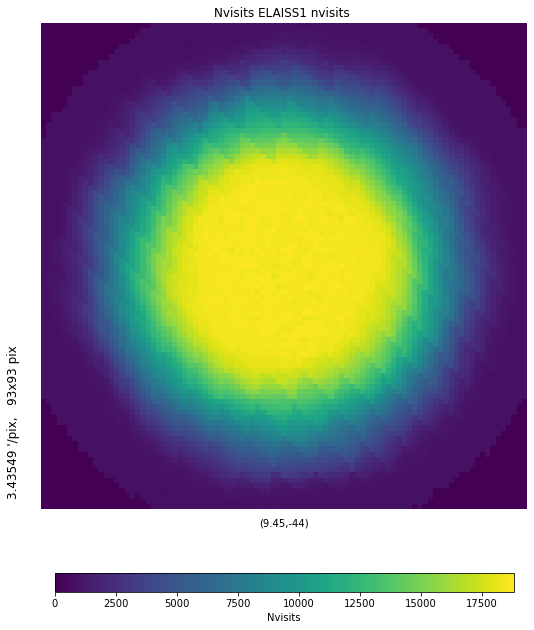

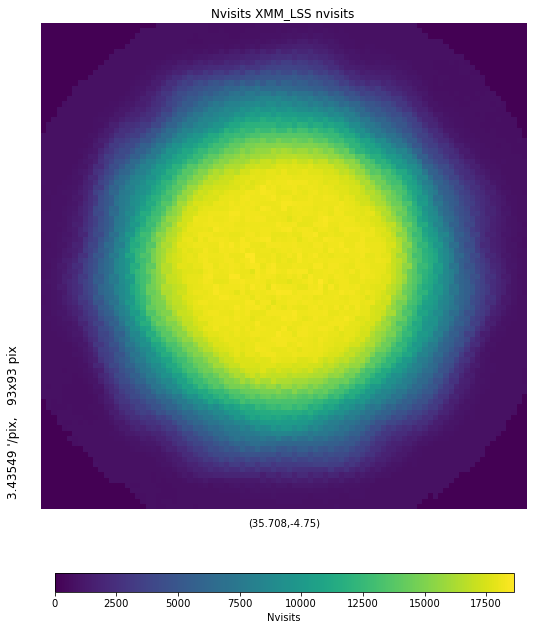

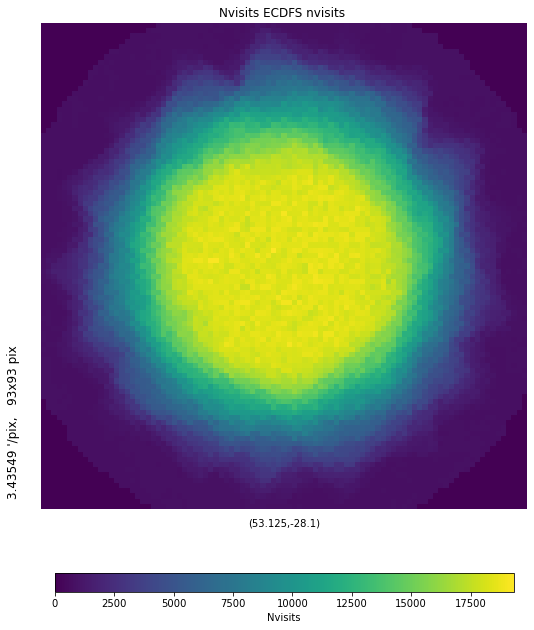

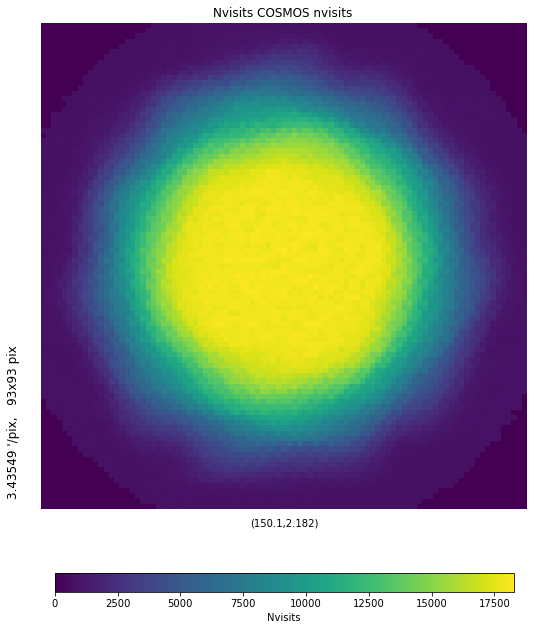

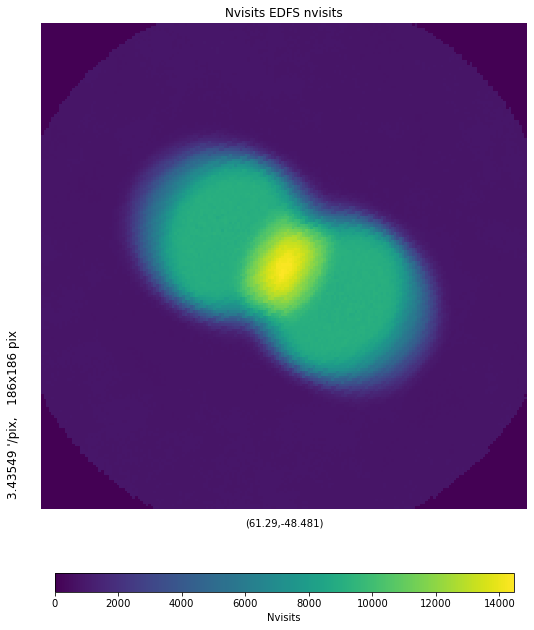

In [18]:
nvisits_bundles = [k for k in bundles if 'nvisits' in k]
for k in nvisits_bundles:
    b = bundles[k]
    skymap = np.zeros(hp.nside2npix(nside), float)
    skymap[b.plotDict['pixs']] = b.metricValues
    fig = plt.figure(figsize=(10, 10))
    hp.gnomview(skymap, fig, rot=b.plotDict['rot'], 
                xsize=b.plotDict['xsize'], 
                reso=b.plotDict['reso'], 
                flip='astro', title='', cbar=False)
    plt.title(f'Nvisits {k}')
    # fix bad color bar
    ax = plt.gca()
    im = ax.get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal', extendrect=True)
    cb.set_label('Nvisits')

/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_49418/3834553096.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


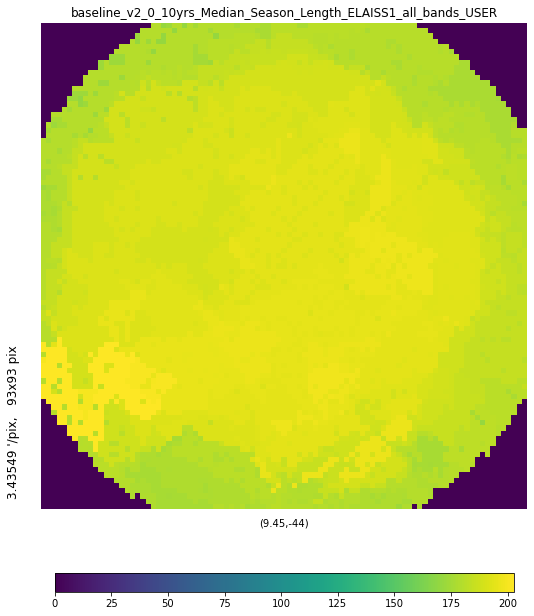

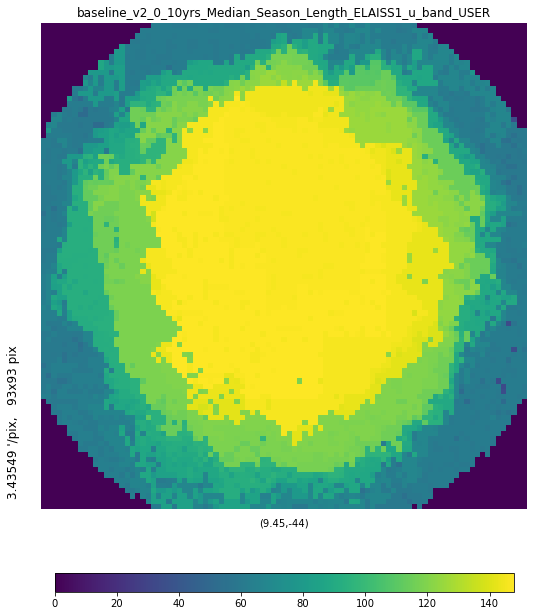

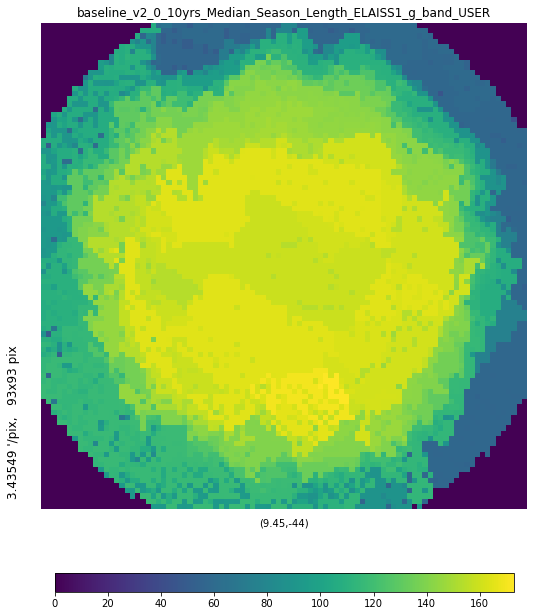

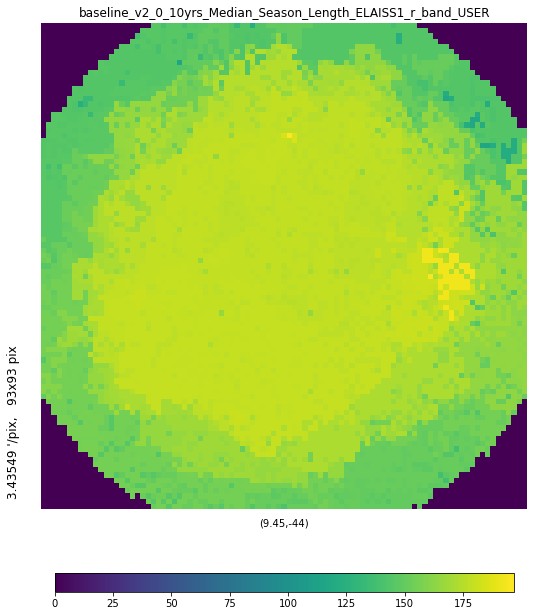

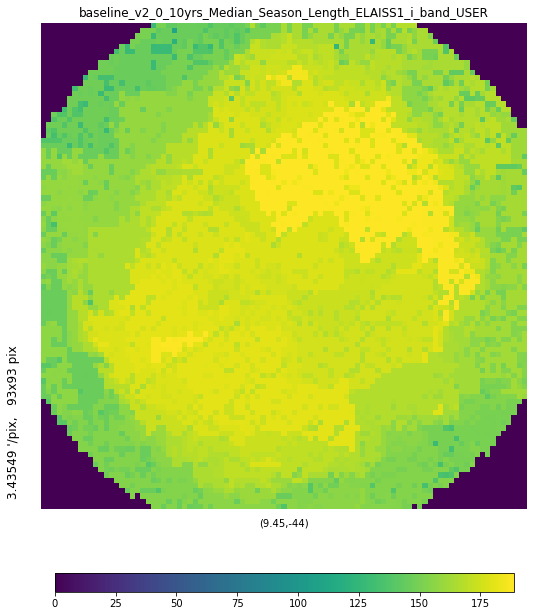

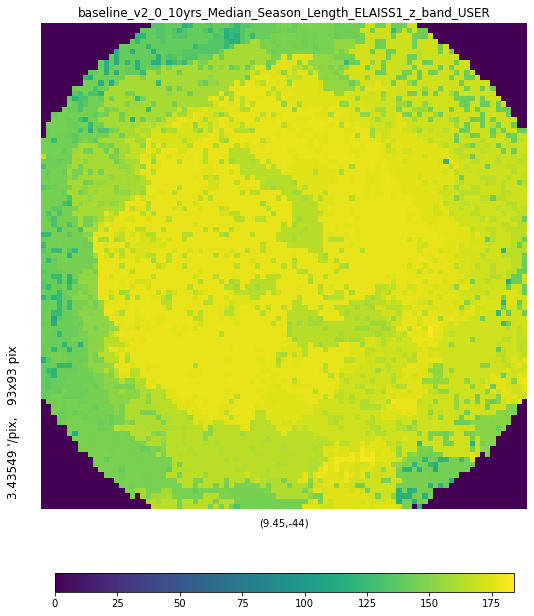

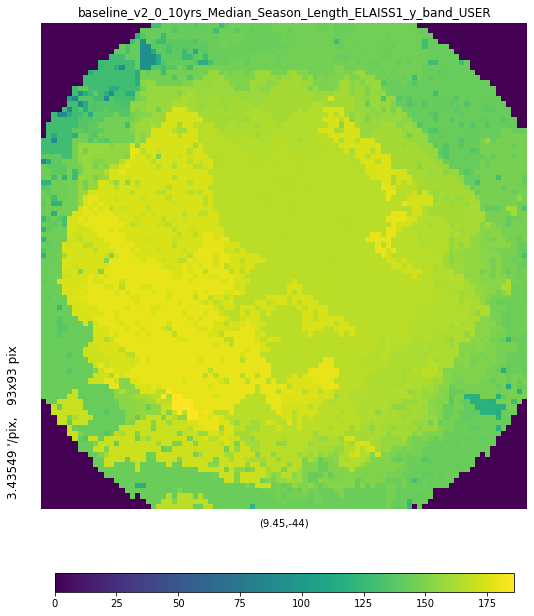

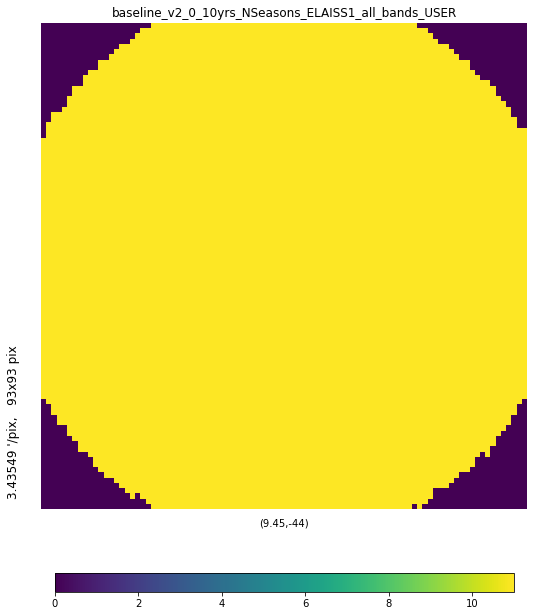

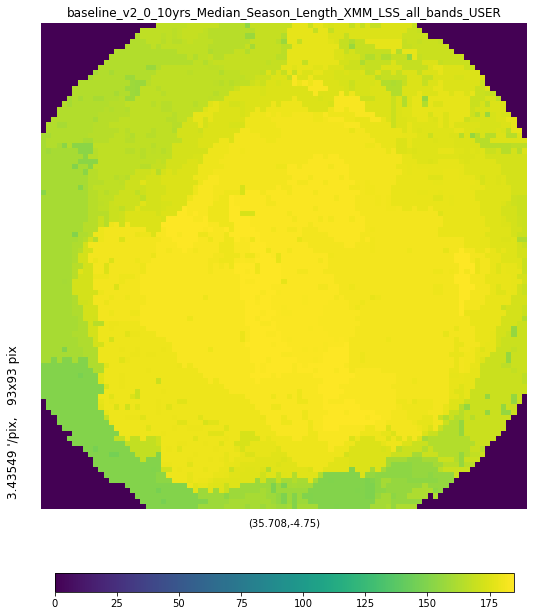

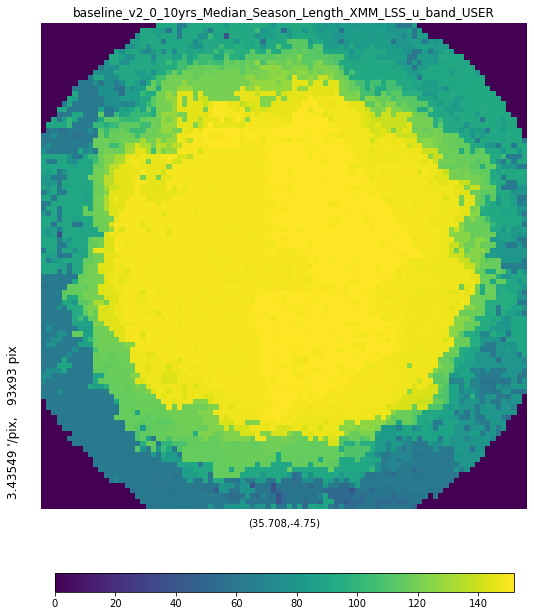

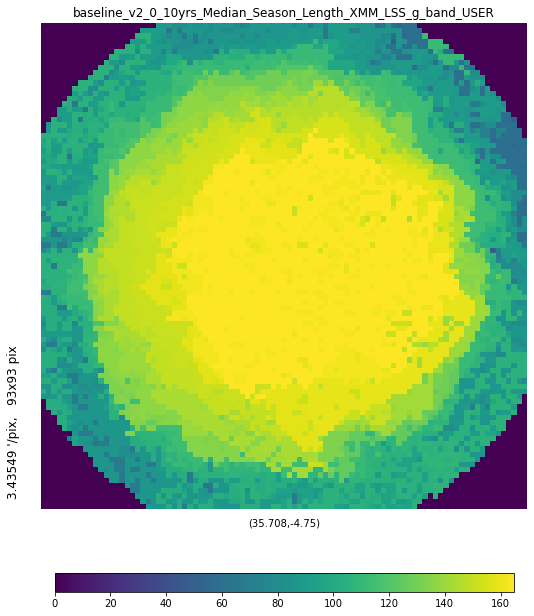

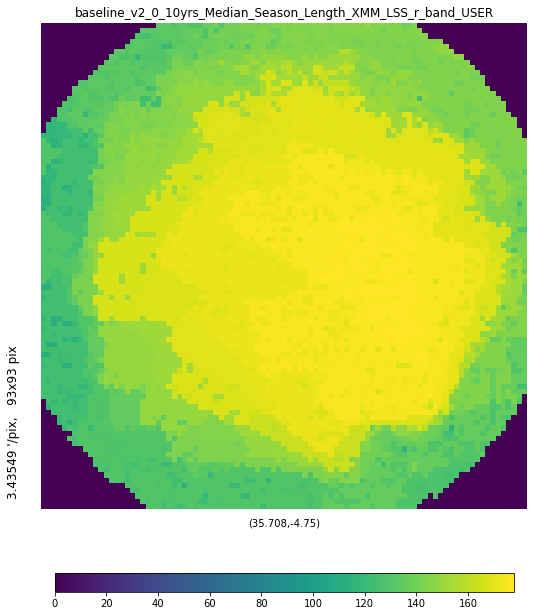

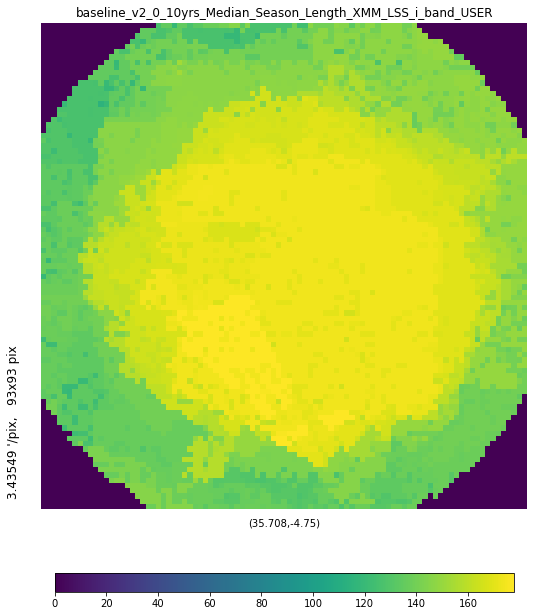

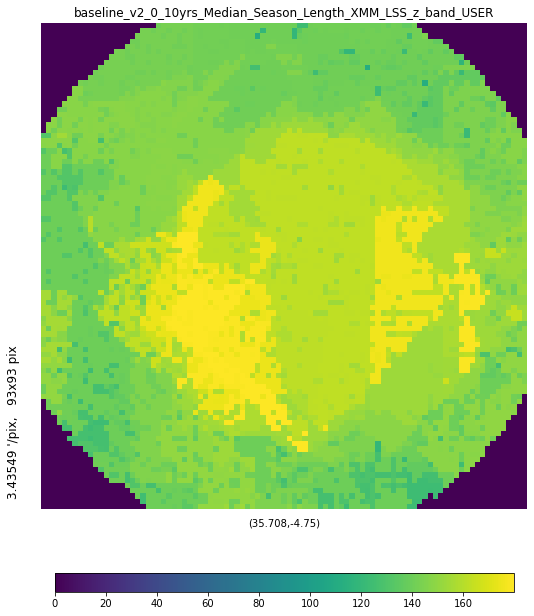

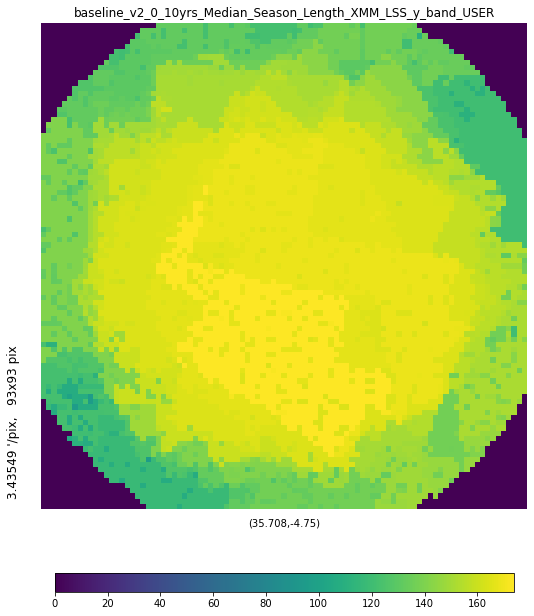

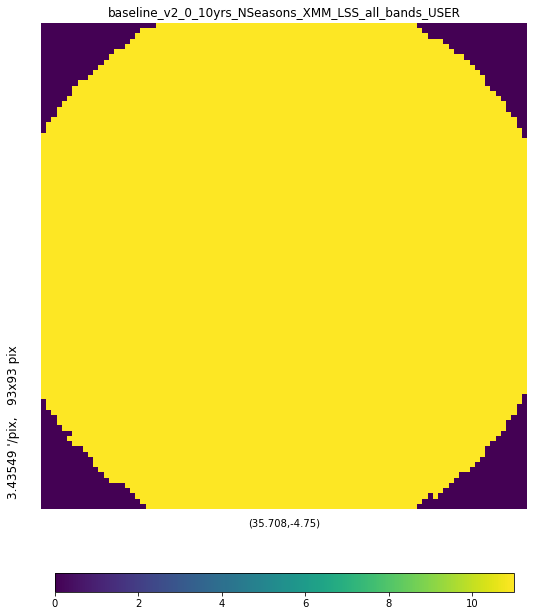

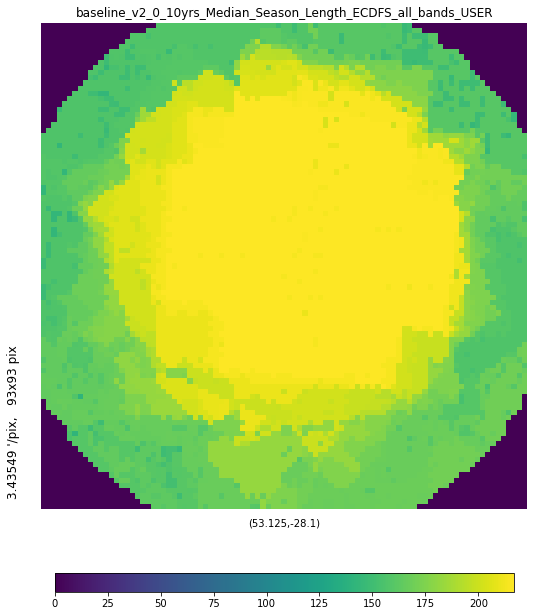

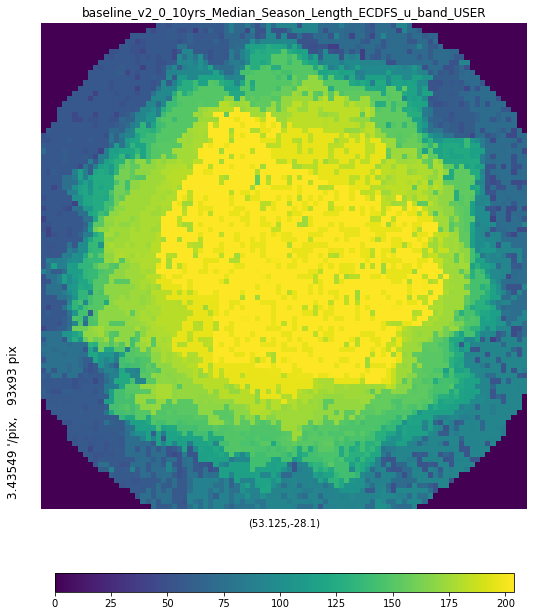

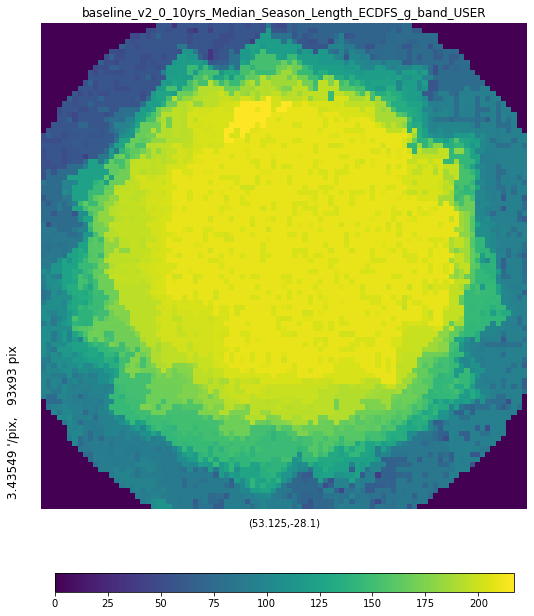

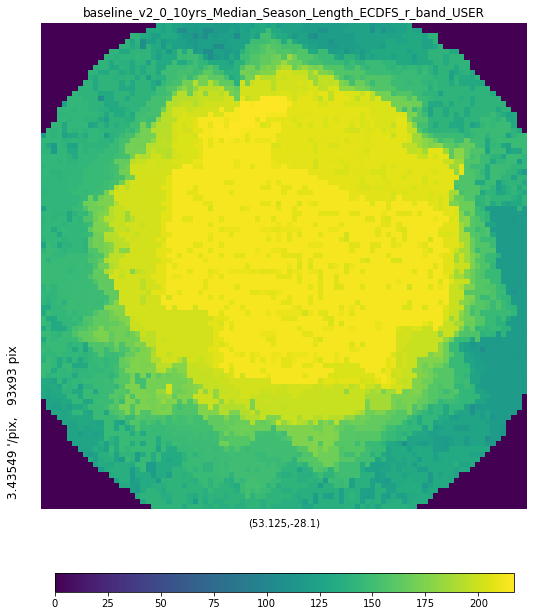

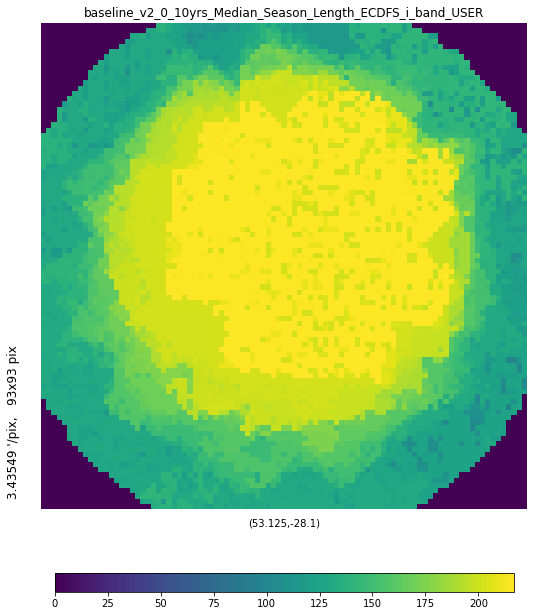

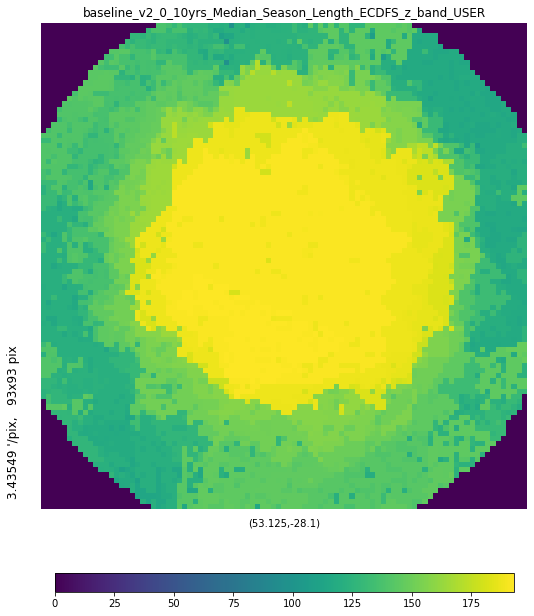

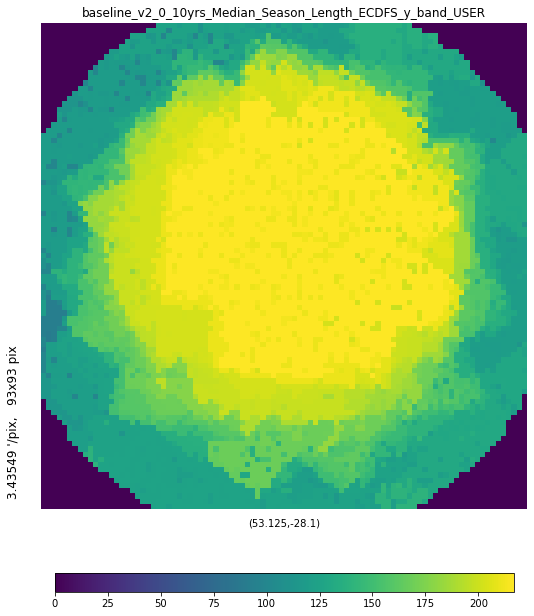

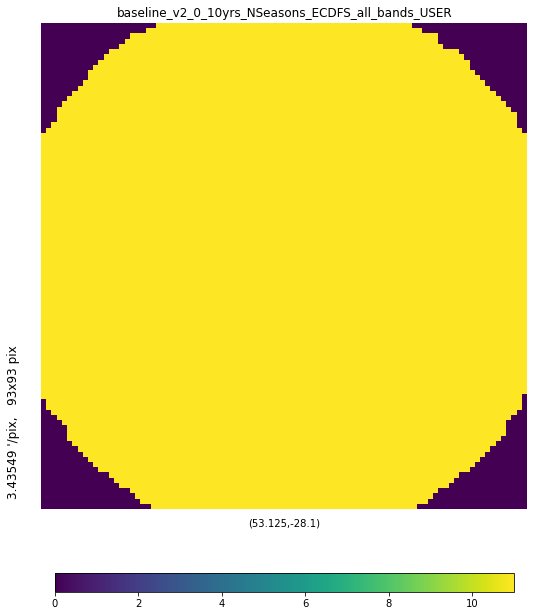

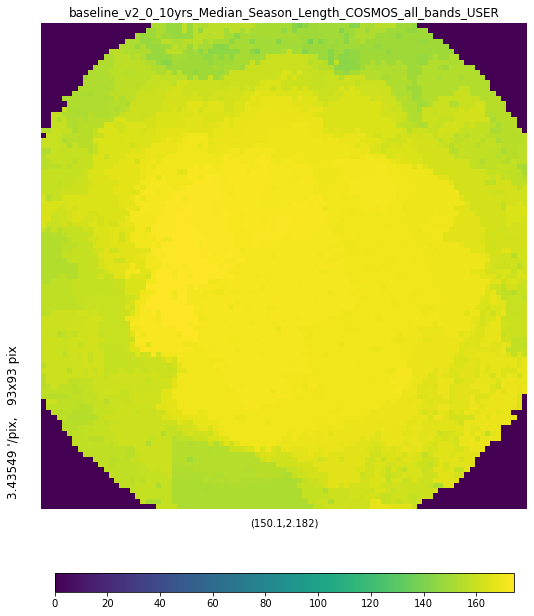

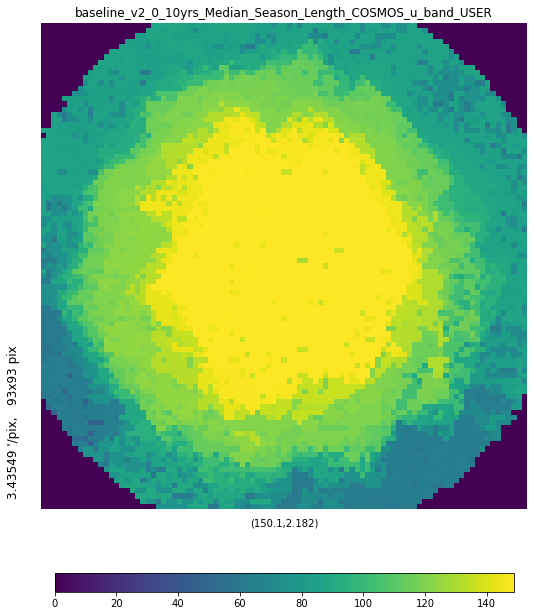

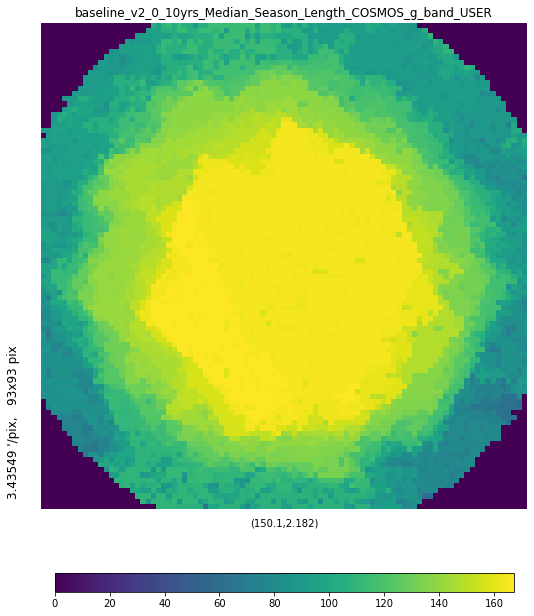

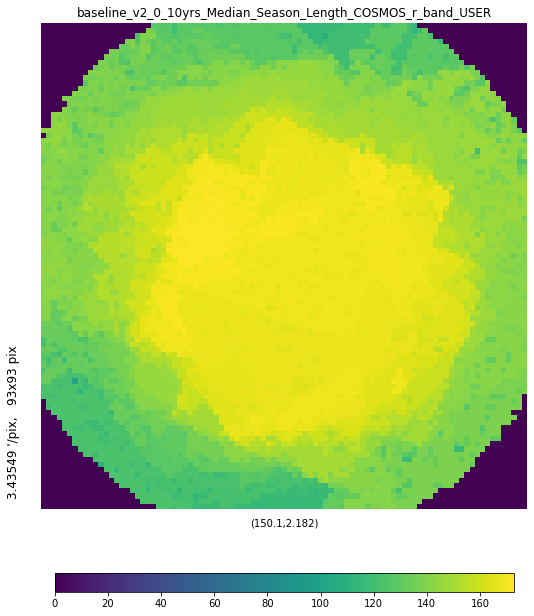

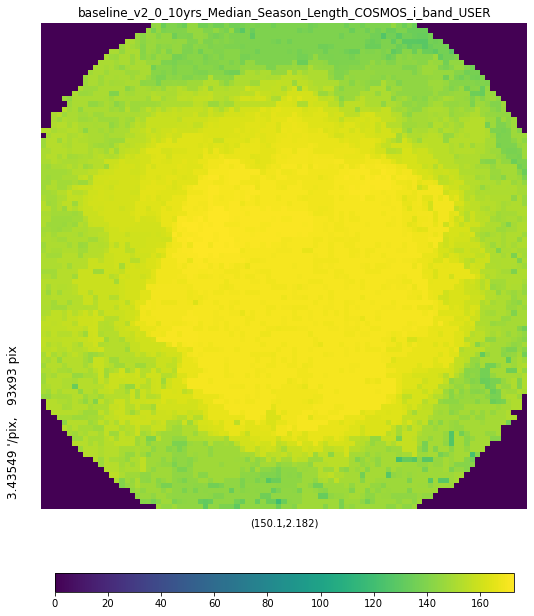

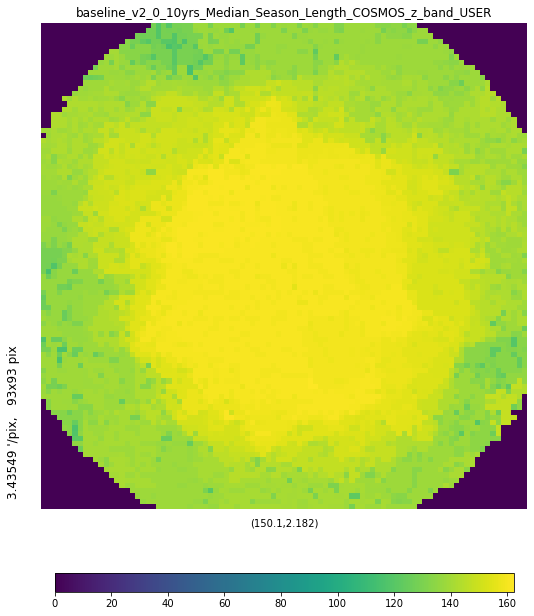

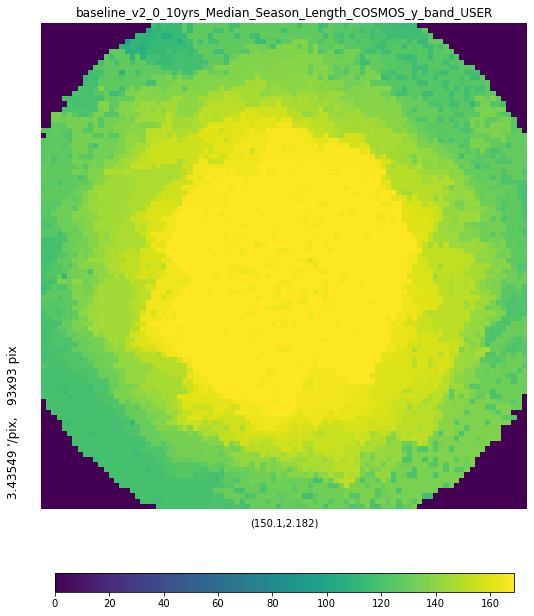

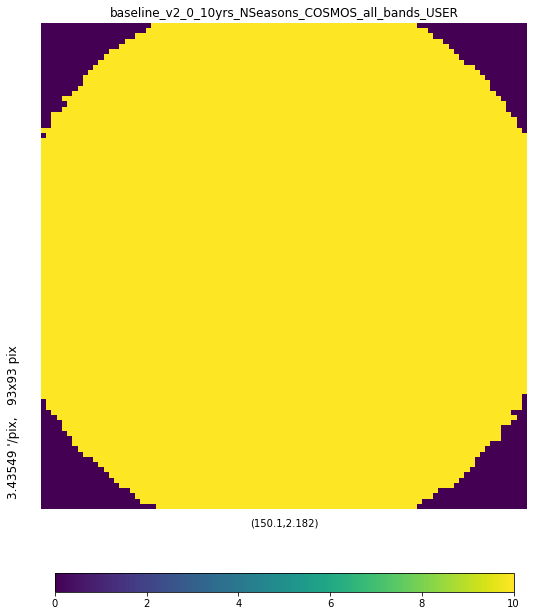

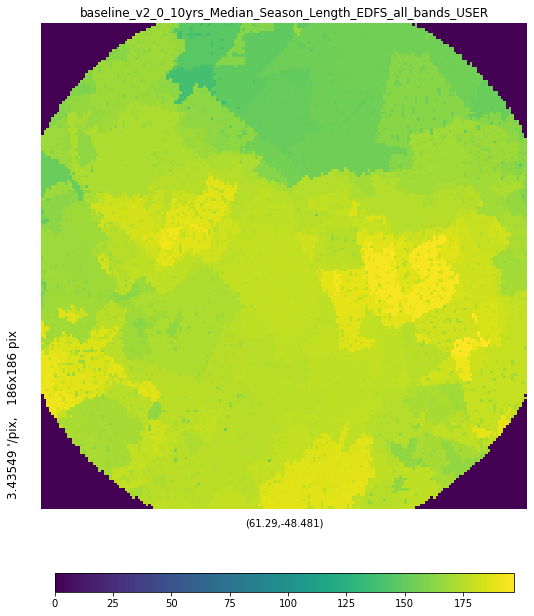

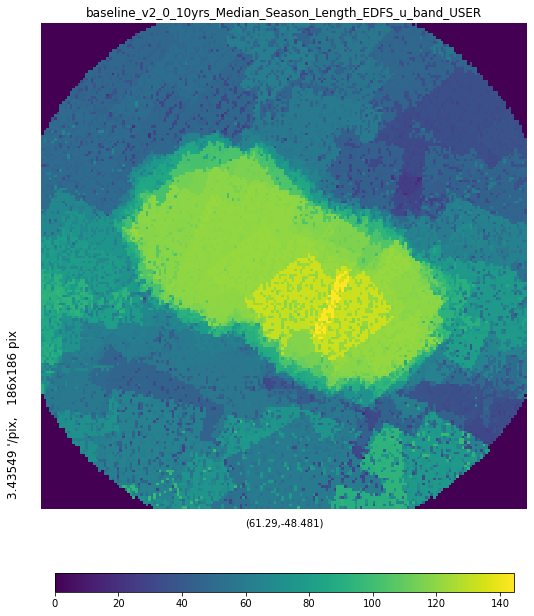

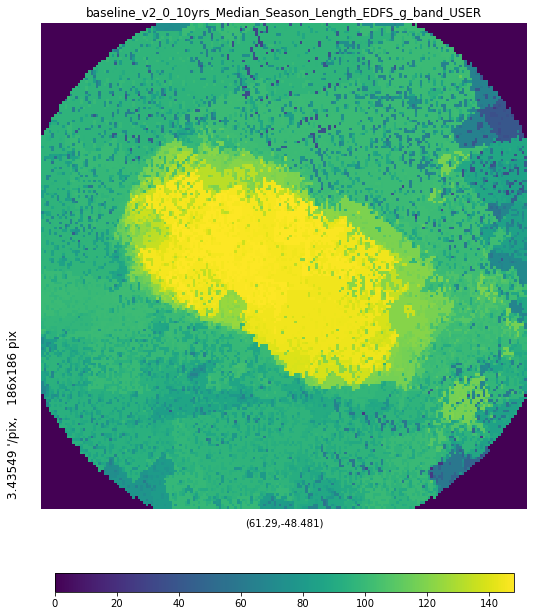

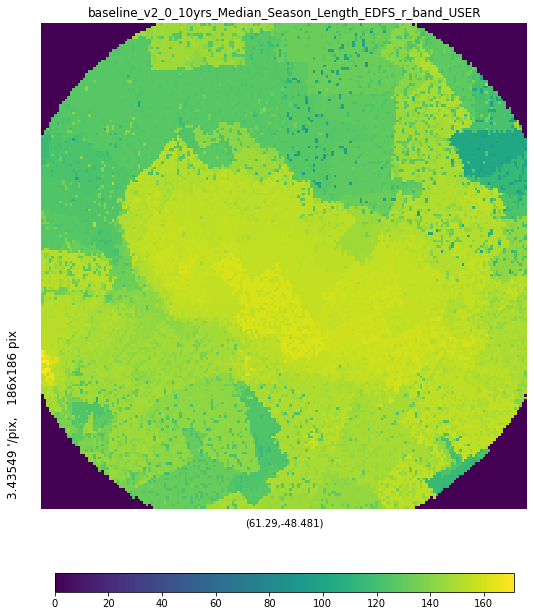

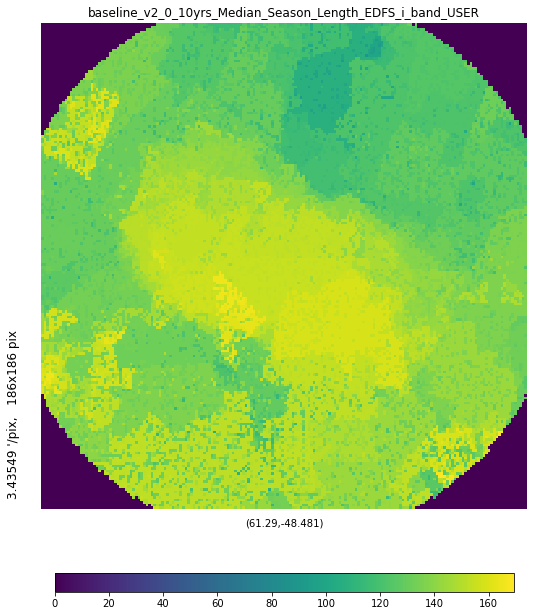

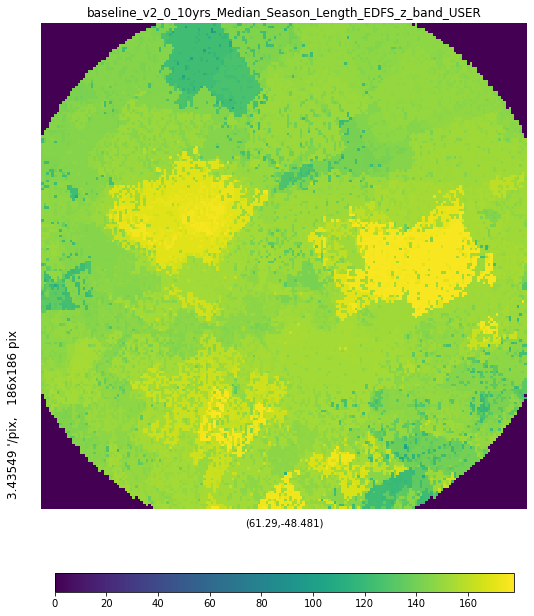

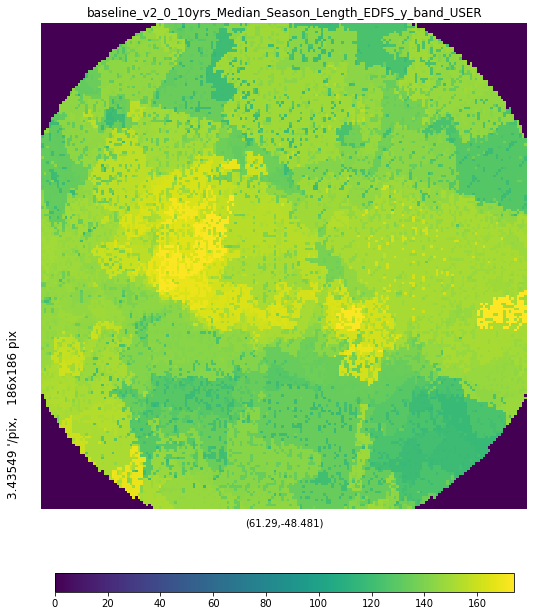

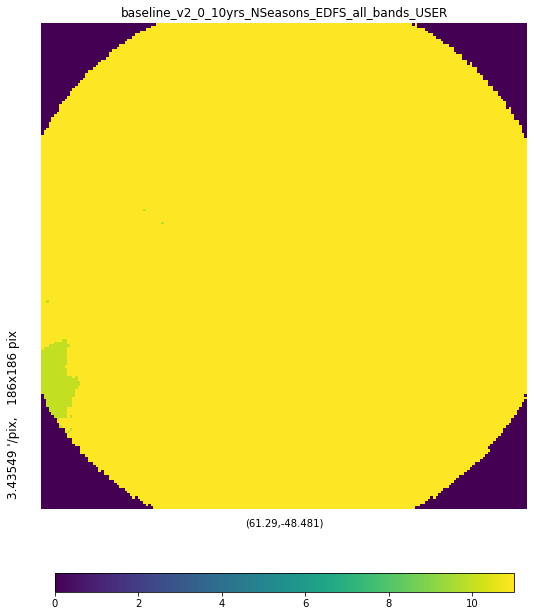

In [19]:
seasons_bundles = [k for k in bundles if 'Season' in k]
for k in seasons_bundles:
    b = bundles[k]
    skymap = np.zeros(hp.nside2npix(nside), float)
    skymap[b.plotDict['pixs']] = b.metricValues
    fig = plt.figure(figsize=(10, 10))
    hp.gnomview(skymap, fig, rot=b.plotDict['rot'], xsize=b.plotDict['xsize'], reso=b.plotDict['reso'], 
                flip='astro', title='', cbar=False)
    plt.title(f'{b.fileRoot}')
    # fix bad color bar
    ax = plt.gca()
    im = ax.get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal', extendrect=True)
    #cb.set_label('Nvisits')

1

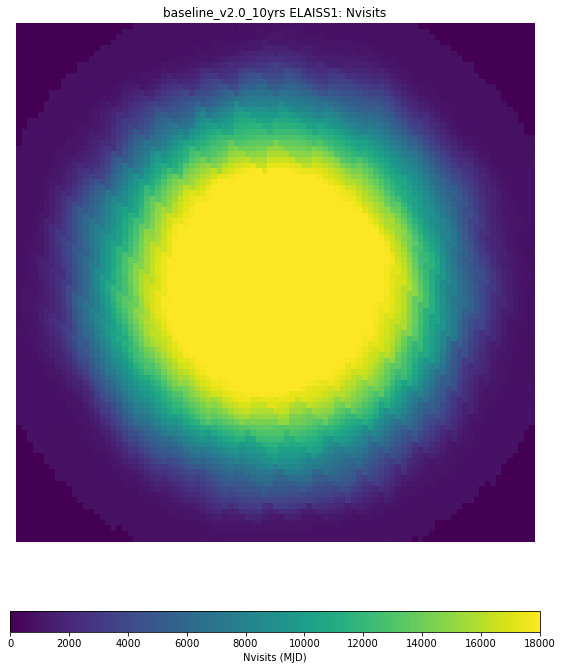

In [25]:
ph = maf.PlotHandler(savefig=False)
ph.setMetricBundles([bundles['ELAISS1 nvisits ']])
ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'visufunc': hp.gnomview,'nside': nside,
                                                 'noGraticule':True, 'figsize': (10, 10),
                                                 'colorMin': 0, 'colorMax': 18000,
                                                'cmap': 'viridis'})